# Variational Auto Encoder

## Load libraries

In [1]:
# import libs that we will use
import random

import numpy as np


import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import sklearn.decomposition as decomposition

# To load the data we will use the script of Gaetan Marceau Caron
import dataset_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Load data

In [2]:
def build_torch_inputs(data):
    xs, ys = data
    result = []

    for x, y in zip(xs, ys):
        result += [{
            "input_tensor": torch.from_numpy(x).reshape(1, -1),
            "output_value": int(y)
        }]
      
    return result

In [3]:
mnist_path = "./mnist.pkl.gz"

# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)
        
train_data = build_torch_inputs(train_data)
dev_data = build_torch_inputs(dev_data)
test_data = build_torch_inputs(test_data)

label: 4


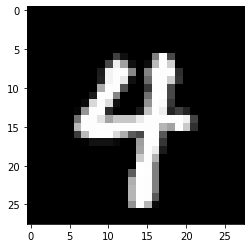

In [4]:
index = 900
label = train_data[index]["output_value"]
picture = train_data[index]["input_tensor"]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='gist_gray')

## Networks

### Encoder

This is the class for the encoder. It learns the parameters of a normal distribution in the latent space and it samples a `z` that follows the learnt distribution.

- `mu = mean`
- `log_sigma_squared = log variance`

The idea is that you use two different output projection: one for `mu`, one for `log_sigma_squared` but all other layers are shared.

In [5]:
class Encoder(nn.Module):
  def __init__(self, dim_latent, init_channels):
    super().__init__()

    self.enc1 = nn.Conv2d(
        in_channels=1, out_channels=init_channels, kernel_size=2, 
        stride=2, padding=1
    )
    self.enc2 = nn.Conv2d(
        in_channels=init_channels, out_channels=init_channels*2, kernel_size=2, 
        stride=2, padding=1
    )
    self.enc3 = nn.Conv2d(
        in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=2, 
        stride=2, padding=1
    )
    self.enc4 = nn.Conv2d(
        in_channels=init_channels*4, out_channels=64, kernel_size=2, 
        stride=2, padding=0
    )

    self.mu_proj = nn.Linear(64, dim_latent)
    self.log_sigma_proj = nn.Linear(64, dim_latent)

    nn.init.xavier_uniform_(self.mu_proj.weight)
    nn.init.zeros_(self.mu_proj.bias)

    nn.init.xavier_uniform_(self.log_sigma_proj.weight)
    nn.init.zeros_(self.log_sigma_proj.bias)

  def forward(self, inputs):
    h = inputs.reshape(-1, 1, 28, 28)
    h = F.relu(self.enc1(h))
    h = F.relu(self.enc2(h))
    h = F.relu(self.enc3(h))
    h = F.relu(self.enc4(h))
    batch, _, _, _ = h.shape
    h = F.adaptive_avg_pool2d(h, 1).reshape(batch, -1)

    self.mu = self.mu_proj(h)
    self.log_sigma_squared = self.log_sigma_proj(h)

    # Reparametrization trick
    e = torch.normal(0, 1.0, self.mu.shape).to(device)
    z = self.mu + e * torch.sqrt(torch.exp(self.log_sigma_squared))

    return z

### Decoder

This is the class for the decoder. It learns the parameters of a normal distribution in the image space using the previous `z` given by the encoder. Then, it samples a image that follows the learnt distribution.

- `mu = mean`
- `log_sigma_squared = log variance`

The idea is that you use two different output projection: one for `mu`, one for `log_sigma_squared` but all other layers are shared.

In [6]:
class Decoder(nn.Module):
  def __init__(self, dim_latent, dim_hidden, dim_output, dropout, sample_decoder):
    super().__init__()

    self.sigmoid = nn.Sigmoid()
    self.sample_decoder = sample_decoder

    tmp_hidden = []
    dim_in = dim_latent
    for dim in dim_hidden:

        # Init hidden layer parameters
        linear = nn.Linear(dim_in, dim)
        nn.init.kaiming_uniform_(linear.weight)
        nn.init.zeros_(linear.bias)

        tmp_hidden += [linear, nn.ReLU(True), nn.Dropout(dropout)]
        dim_in = dim

    self.hidden_layers = nn.Sequential(*tmp_hidden)

    self.mu_proj = nn.Linear(dim_in, dim_output)
    self.log_sigma_proj = nn.Linear(dim_in, dim_output)

    nn.init.xavier_uniform_(self.mu_proj.weight)
    nn.init.zeros_(self.mu_proj.bias)

    nn.init.xavier_uniform_(self.log_sigma_proj.weight)
    nn.init.zeros_(self.log_sigma_proj.bias)

  def forward(self, inputs):
    h = self.hidden_layers(inputs)

    self.mu = self.mu_proj(h)
    if not self.sample_decoder:
      return self.sigmoid(self.mu)
      
    self.log_sigma_squared = self.log_sigma_proj(h)

    # Reparametrization trick
    e = torch.normal(0, 1.0, self.mu.shape).to(device)
    image = self.mu + e * torch.sqrt(torch.exp(self.log_sigma_squared))

    return self.sigmoid(image)

### Variational AutoEncoder

This class is the concatenation of the two previous one. It allow us to see the ensemble (encoder + decoder) as a single network.

In [7]:
class VAE(nn.Module):
  def __init__(self, dim_input, dim_hidden, dim_latent, init_channels=8, dropout=0.0, sample_decoder=True):
    super().__init__()

    self.encoder = Encoder(dim_latent, init_channels)
    self.decoder = Decoder(dim_latent, dim_hidden, dim_input, dropout, sample_decoder)

  def forward(self, x):
    x = x.to(device)

    z = self.encoder(x)
    return self.decoder(z)

## Training

### Loss

We want to maximize the objective `reconstruction_loss - kl`.

In [8]:
def loss(encoder, x_hat, x):
    kl = (
        -0.5
        * torch.sum(
            1
            + encoder.log_sigma_squared
            - encoder.mu.pow(2)
            - encoder.log_sigma_squared.exp(),
            dim=1,
        ).mean()
    )

    reconstruction_loss = -((x.to(device) - x_hat) ** 2).sum(dim=1).mean()  # -L2 loss

    return -(reconstruction_loss - kl) # Pytorch only accepts loss function

### Helper functions

In [9]:
def build_batch(data):
    batch_inputs = torch.cat([data["input_tensor"] for data in data], dim=0)
    labels = torch.LongTensor([data["output_value"] for data in data])

    return batch_inputs, labels

credits: https://medium.com/dataseries/variational-autoencoder-with-pytorch-2d359cbf027b

In [10]:
def plot_ae_outputs(vae, n=10):
    random.shuffle(dev_data)
    plt.figure(figsize=(16, 4.5))

    t_idx = []
    for i in range(n):
        count = 0
        while True:
            if dev_data[count]["output_value"] == i:
                break
            count += 1
        t_idx.append(count)

    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        img = dev_data[t_idx[i]]["input_tensor"]

        vae.eval()

        with torch.no_grad():
            rec_img = vae(img)

        img = img.reshape(28, 28, 1)

        plt.imshow(img.cpu().squeeze().numpy(), cmap="gist_gray")

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if i == n // 2:
            ax.set_title("Original images")

        ax = plt.subplot(2, n, i + 1 + n)
        
        rec_img = rec_img.reshape(28, 28, 1)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap="gist_gray")

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if i == n // 2:
            ax.set_title("Reconstructed images")

    plt.show()

In [11]:
def compute_loss(vae, data_set, batch_size):
    vae.eval()
    val_loss = 0.0

    with torch.no_grad():
        nb_batches = 0

        for first_element in range(0, len(data_set), batch_size):
            xs, _ = build_batch(data_set[first_element : first_element + batch_size])
            xs_hat = vae(xs)
            
            l = loss(vae.encoder, xs_hat, xs)

            val_loss += l.item()
            nb_batches += 1

    return val_loss / nb_batches

### Training loop

In [12]:
def training_loop(vae, optimizer, n_epochs, batch_size, verbose=True, plots=True):
    train_losses = []
    dev_losses = []

    for epoch in range(n_epochs):
        vae.train()
        random.shuffle(train_data)

        avg_loss = 0
        nb_batches = 0

        for first_element in range(0, len(train_data), batch_size):
            optimizer.zero_grad()

            xs, _ = build_batch(train_data[first_element : first_element + batch_size])
            xs_hat = vae(xs)
            
            l = loss(vae.encoder, xs_hat, xs)
            l.backward()

            avg_loss += l.item()
            nb_batches += 1

            nn.utils.clip_grad_value_(vae.parameters(), 5.0)
            optimizer.step()

        train_losses += [avg_loss / nb_batches]
        dev_losses += [compute_loss(vae, dev_data, batch_size)]

        if verbose:
            print(f"epoch {epoch+1}/{n_epochs}")
            print(f"training loss: {train_losses[-1]:.4f}")
            print(f"dev loss: {dev_losses[-1]:.4f}")

        if plots:
            plot_ae_outputs(vae, 10)

    if verbose:
        print(f"test loss: {compute_loss(vae, test_data, batch_size):.4f}")

    return {"train_losses": train_losses, "dev_losses": dev_losses}

### Visualization functions

In [13]:
def plot_results(history, n_epochs):
  x = range(0, n_epochs)
  plt.figure(figsize=(8, 5))
  plt.plot(x, history["train_losses"], color="r", label="train loss")
  plt.xlabel("epoch")
  plt.legend()
  plt.show()

  plt.figure(figsize=(8, 5))
  plt.plot(x, history["dev_losses"], color="b", label="dev loss")
  plt.xlabel("epoch")
  plt.legend()
  plt.show()

colormap is between 0 and 1, and we have 10 classes so we just divide by 10 :) https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html

In [14]:
def visualize_latent_space(vae, data, dim_latent, batch_size):
    vae.eval()

    data_labels = np.empty(len(data))
    points = np.empty((len(data), dim_latent))

    with torch.no_grad():
        for i in range(0, len(data), batch_size):
            batch, labels = build_batch(train_data[i : i + batch_size])
            # VAE, keep only the mean
            batch = batch.to(device)
            vae.encoder(batch)
            points[i : i + batch_size] = vae.encoder.mu.detach().cpu().numpy()
            data_labels[i : i + batch_size] = labels.numpy()

    if dim_latent > 2:
        pca = decomposition.PCA(n_components=2)
        points = pca.fit_transform(points)

    plt.scatter(
        points[:, 0],
        points[:, 1],
        c=matplotlib.cm.get_cmap("tab10")(data_labels / 10.0),
    )


In [15]:
def plot_random(decoder, nb_images=10):
    decoder.eval()

    with torch.no_grad():
        e = torch.normal(0, 1.0, (nb_images, dim_latent)).to(device)
        images = decoder(e)

    fig, axs = plt.subplots(1, nb_images)

    size = 15
    fig.set_size_inches(size, nb_images * size)

    for ax, image in zip(axs, images):
        ax.imshow(
            image.clone().detach().cpu().numpy().reshape(28, 28), cmap="gist_gray"
        )

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Training

epoch 1/70
training loss: 56.5218
dev loss: 50.6121


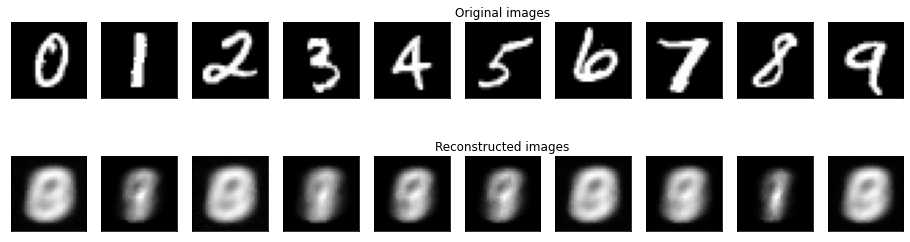

epoch 2/70
training loss: 49.1486
dev loss: 46.5063


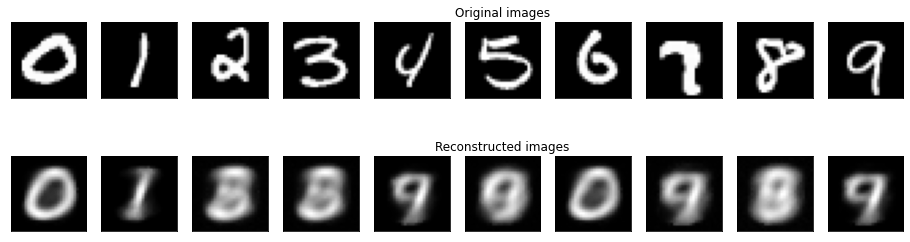

epoch 3/70
training loss: 47.0991
dev loss: 45.1683


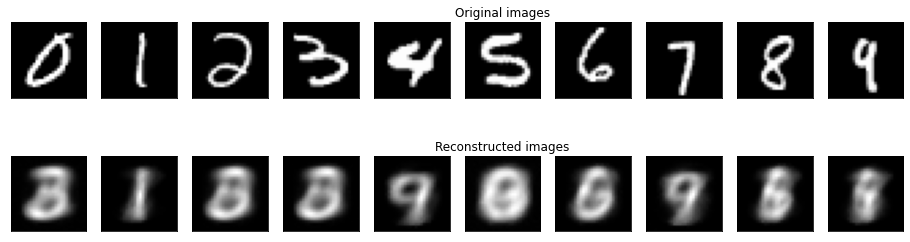

epoch 4/70
training loss: 45.6566
dev loss: 42.9132


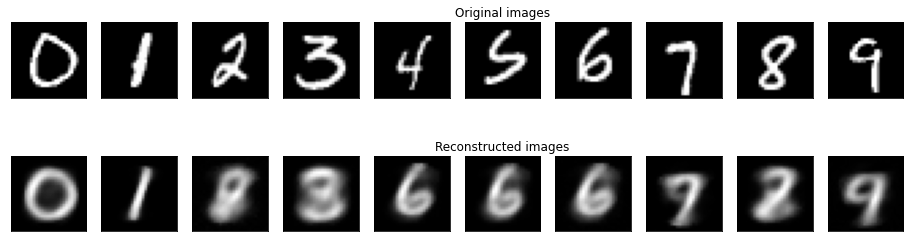

epoch 5/70
training loss: 42.0282
dev loss: 37.7363


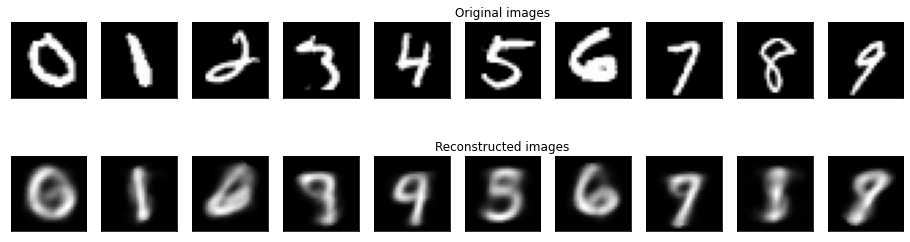

epoch 6/70
training loss: 39.4298
dev loss: 36.2809


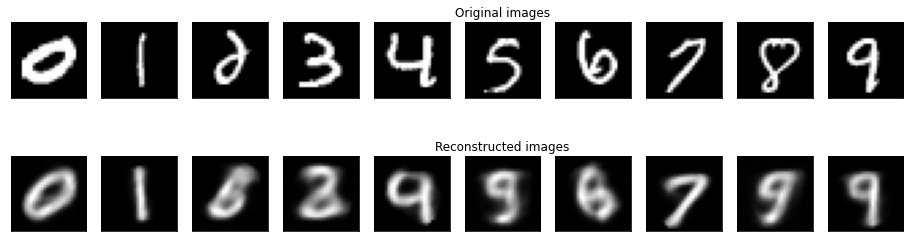

epoch 7/70
training loss: 38.5700
dev loss: 35.5763


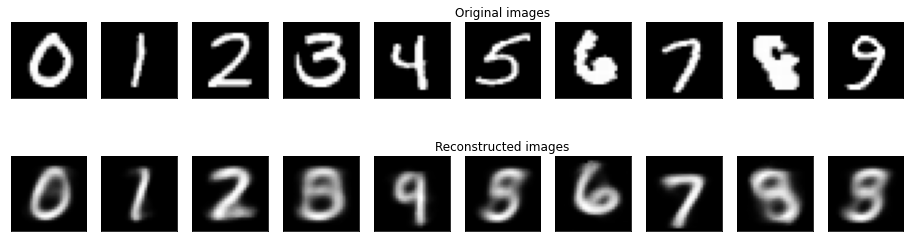

epoch 8/70
training loss: 37.8875
dev loss: 35.0780


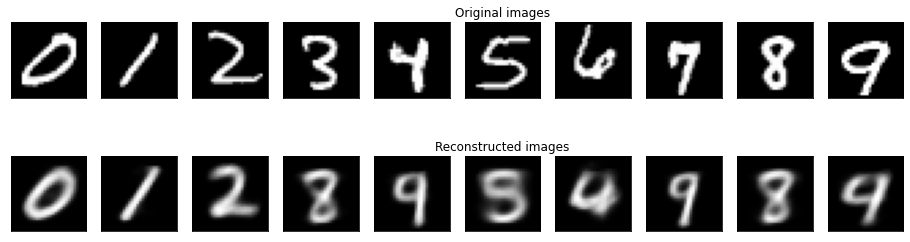

epoch 9/70
training loss: 37.4967
dev loss: 34.7254


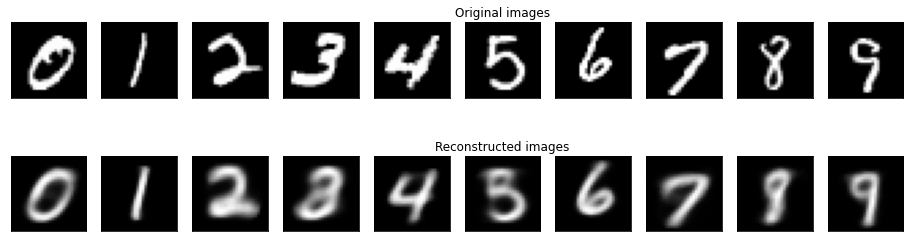

epoch 10/70
training loss: 37.1874
dev loss: 34.4357


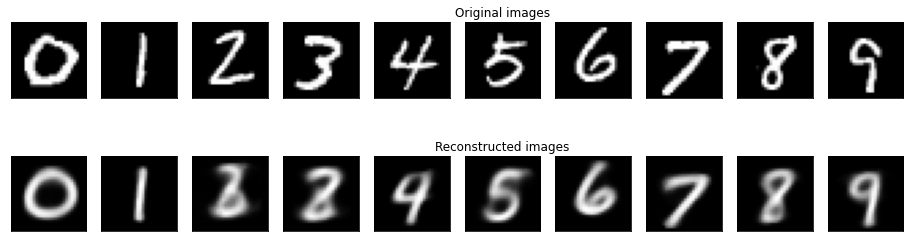

epoch 11/70
training loss: 36.8979
dev loss: 34.2281


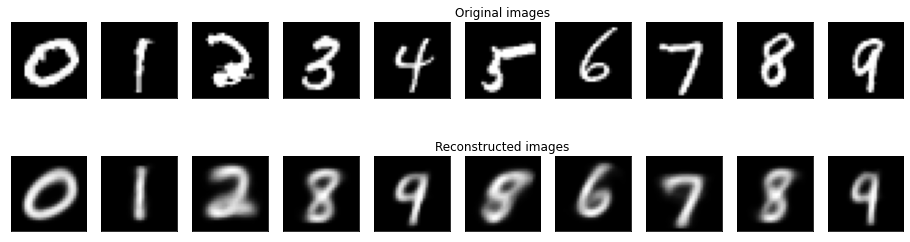

epoch 12/70
training loss: 36.7011
dev loss: 34.1677


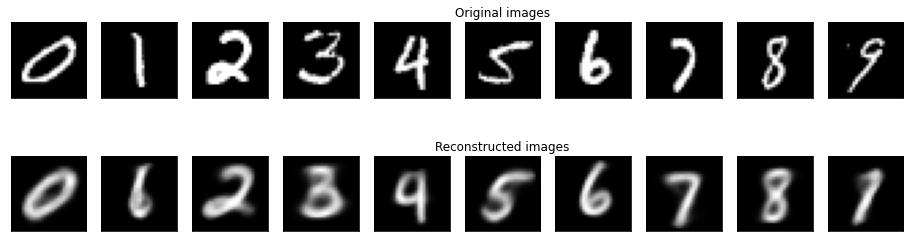

epoch 13/70
training loss: 36.4961
dev loss: 34.0217


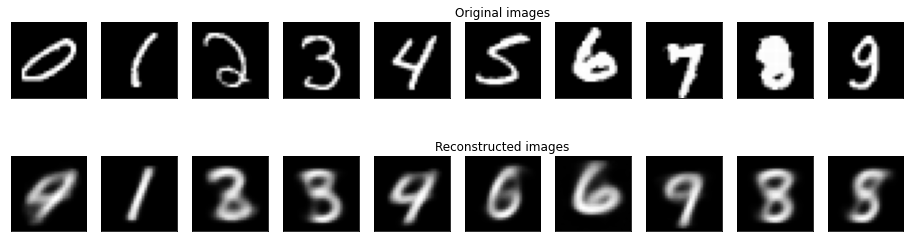

epoch 14/70
training loss: 36.3798
dev loss: 33.7826


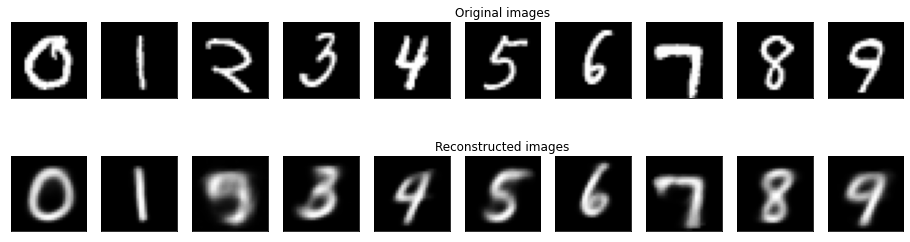

epoch 15/70
training loss: 36.2577
dev loss: 33.7624


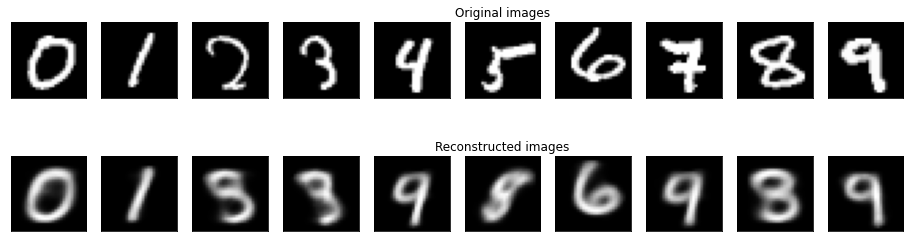

epoch 16/70
training loss: 36.1127
dev loss: 33.6698


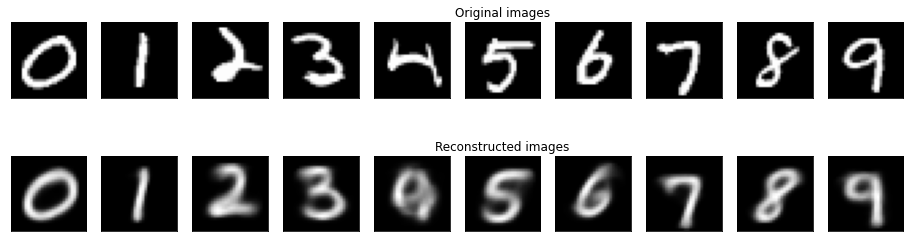

epoch 17/70
training loss: 36.0410
dev loss: 33.4836


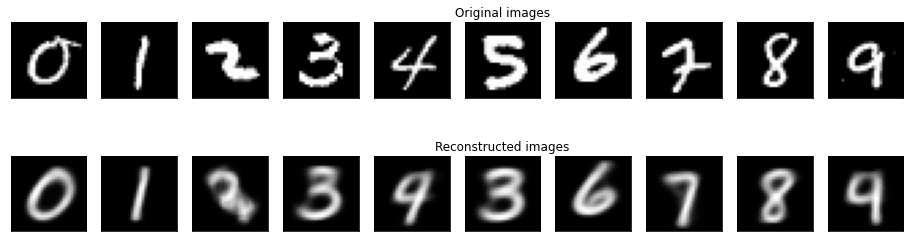

epoch 18/70
training loss: 35.9591
dev loss: 33.4304


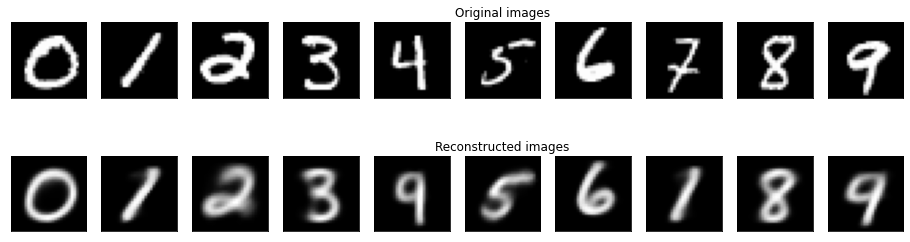

epoch 19/70
training loss: 35.8778
dev loss: 33.3694


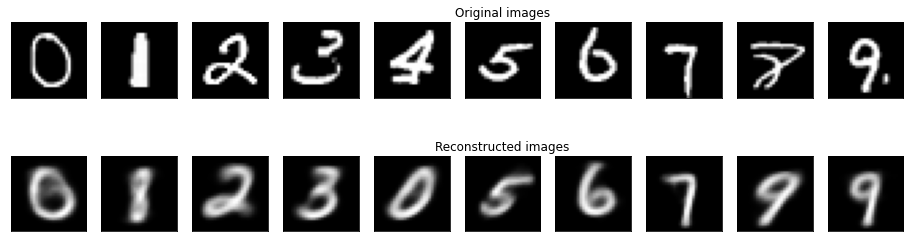

epoch 20/70
training loss: 35.8140
dev loss: 33.3793


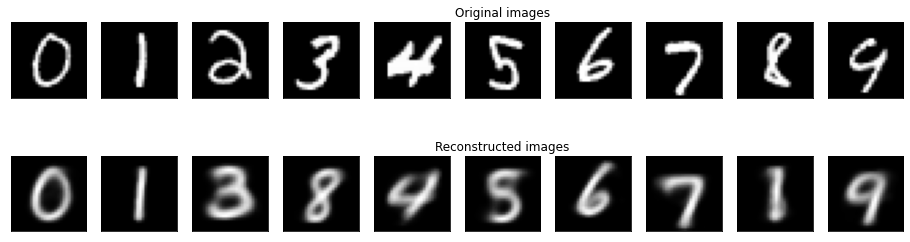

epoch 21/70
training loss: 35.7352
dev loss: 33.2309


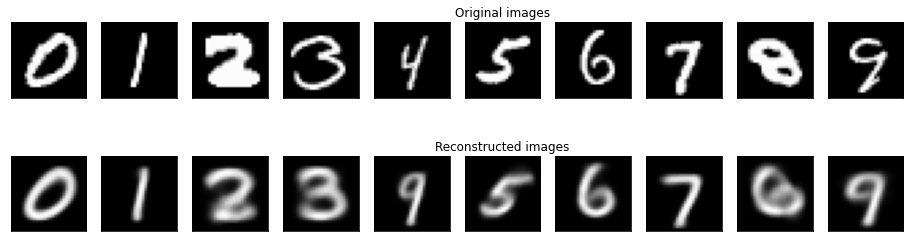

epoch 22/70
training loss: 35.6352
dev loss: 33.1513


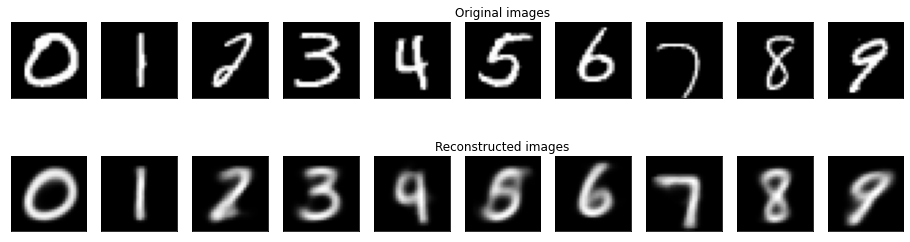

epoch 23/70
training loss: 35.5907
dev loss: 33.1197


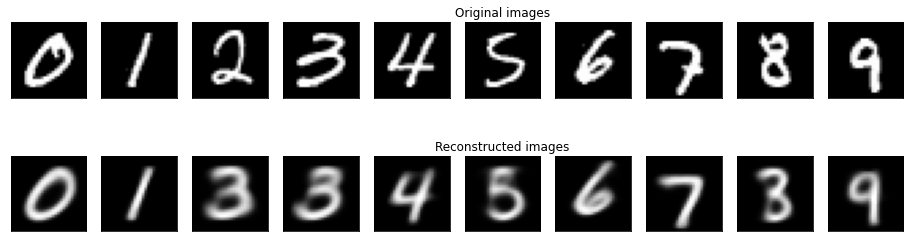

epoch 24/70
training loss: 35.5431
dev loss: 33.0660


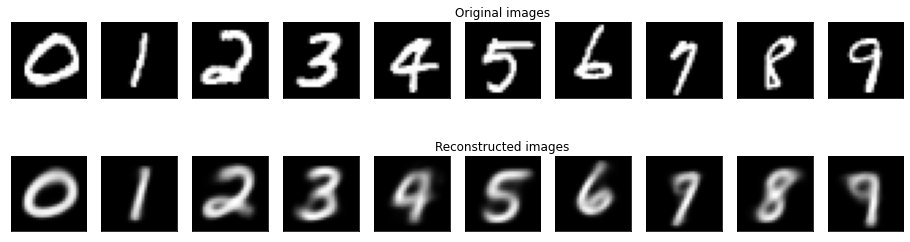

epoch 25/70
training loss: 35.4595
dev loss: 33.0345


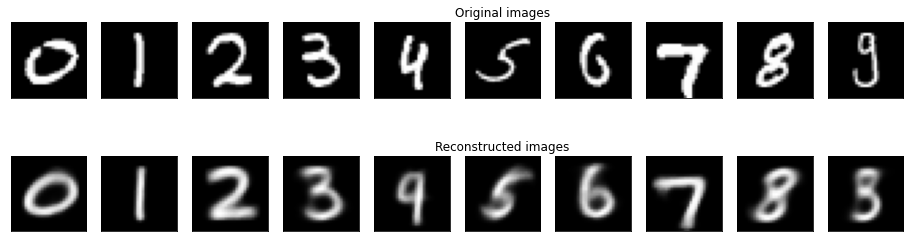

epoch 26/70
training loss: 35.4293
dev loss: 32.9925


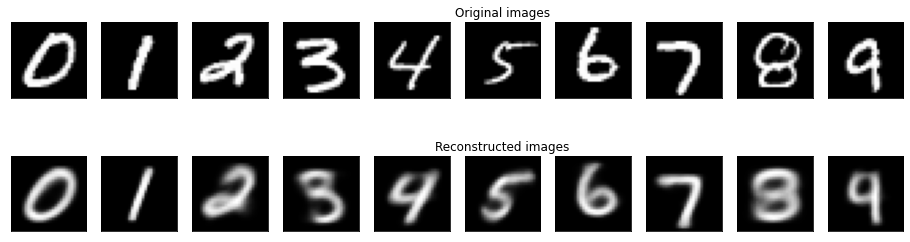

epoch 27/70
training loss: 35.4028
dev loss: 33.0679


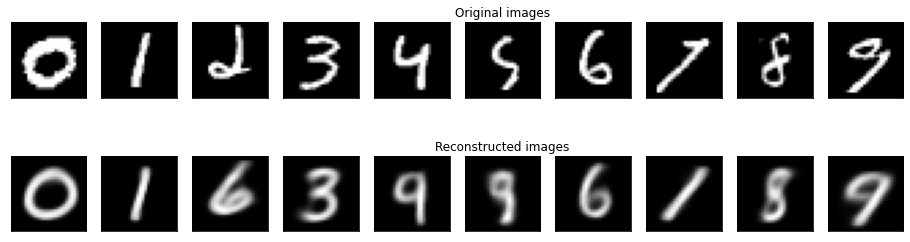

epoch 28/70
training loss: 35.3780
dev loss: 33.0265


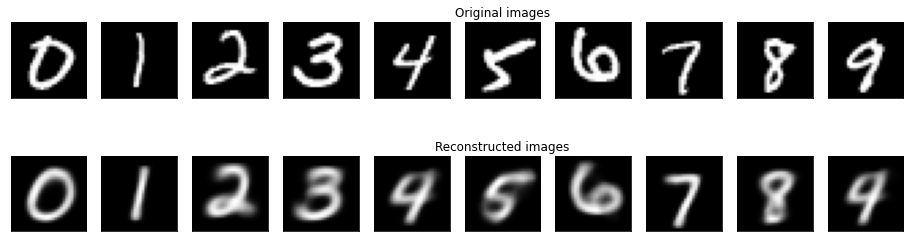

epoch 29/70
training loss: 35.3402
dev loss: 32.8848


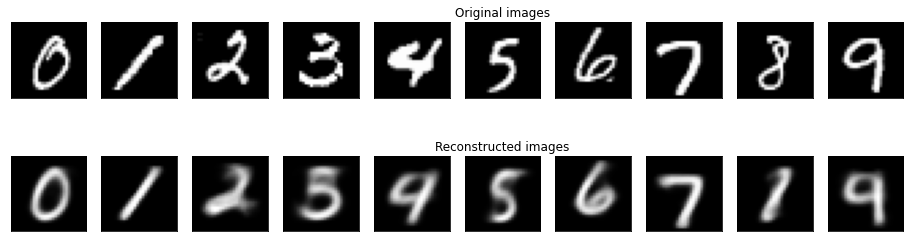

epoch 30/70
training loss: 35.2586
dev loss: 32.9900


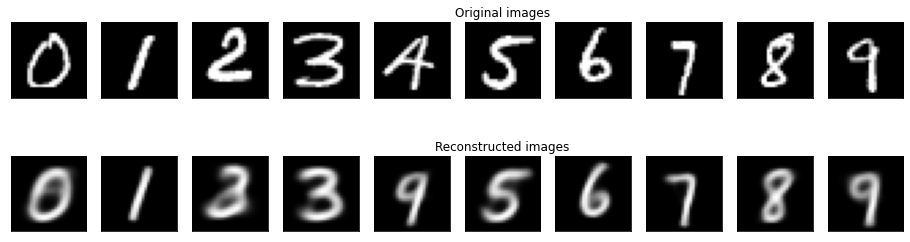

epoch 31/70
training loss: 35.2153
dev loss: 32.9108


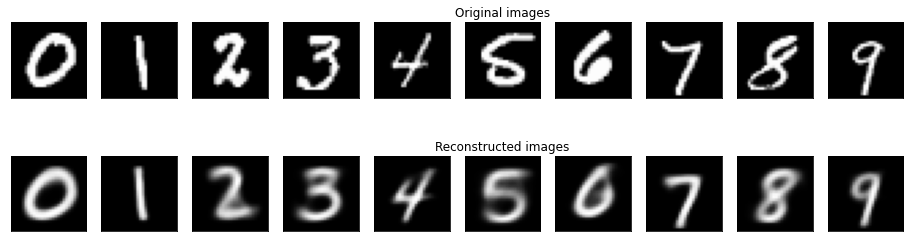

epoch 32/70
training loss: 35.1695
dev loss: 32.7075


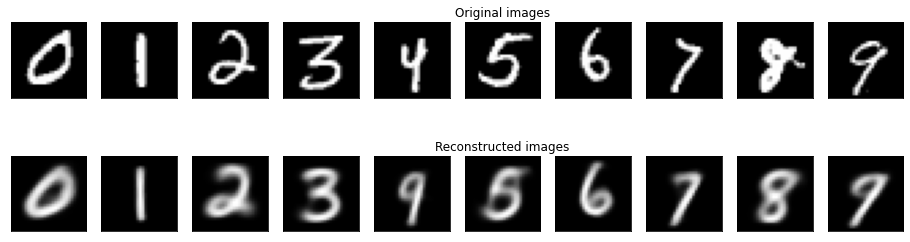

epoch 33/70
training loss: 35.1606
dev loss: 32.7162


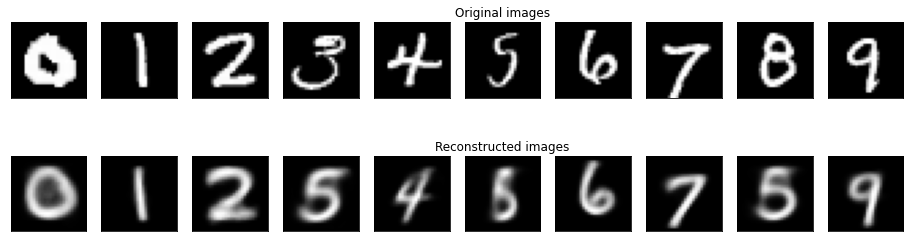

epoch 34/70
training loss: 35.1389
dev loss: 32.7555


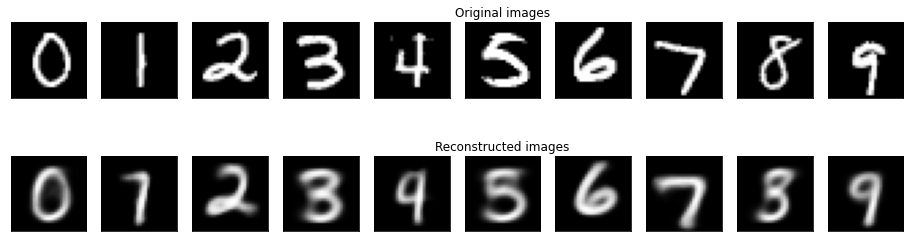

epoch 35/70
training loss: 35.1393
dev loss: 32.7710


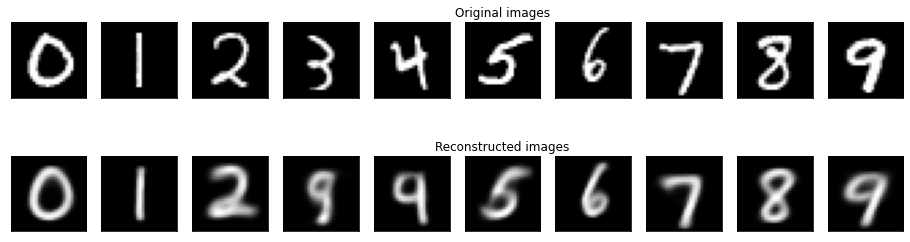

epoch 36/70
training loss: 35.1306
dev loss: 32.7230


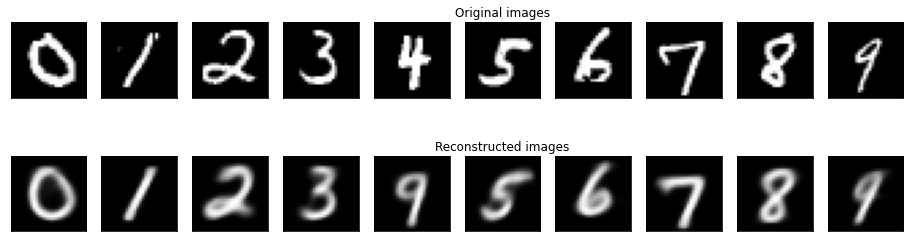

epoch 37/70
training loss: 35.0702
dev loss: 32.6565


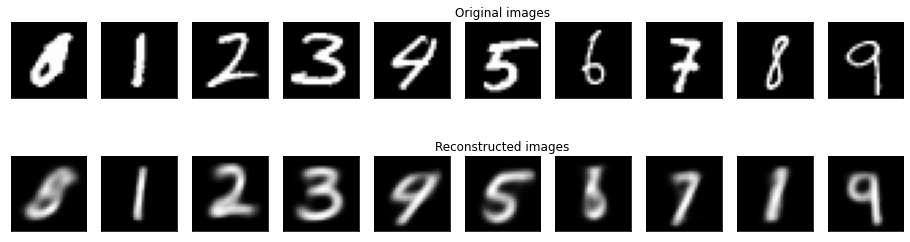

epoch 38/70
training loss: 35.0660
dev loss: 32.6280


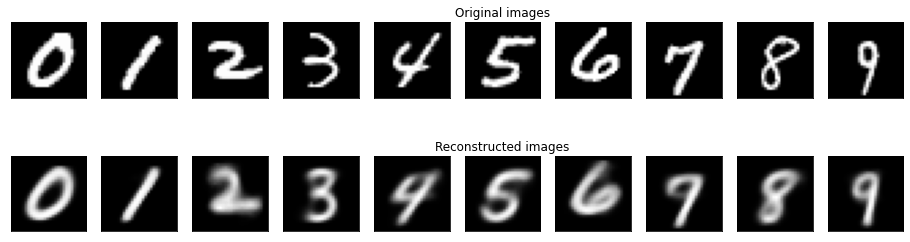

epoch 39/70
training loss: 35.0158
dev loss: 32.5907


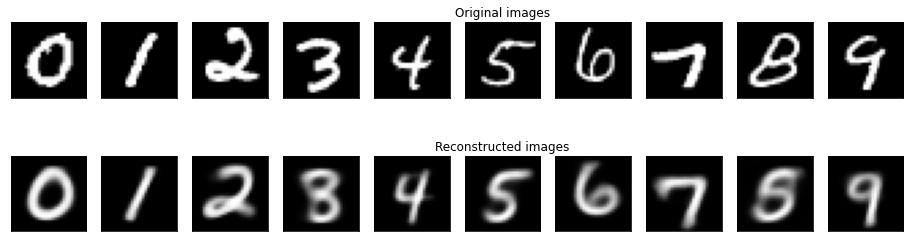

epoch 40/70
training loss: 34.9993
dev loss: 32.5328


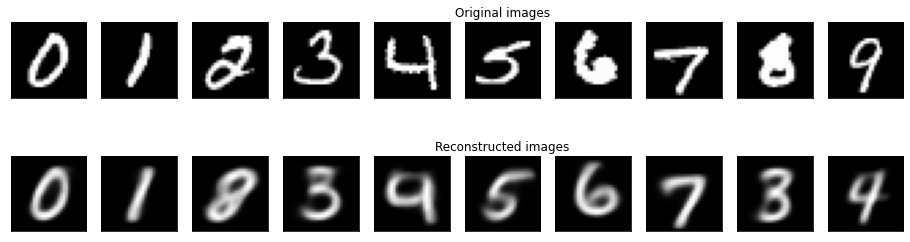

epoch 41/70
training loss: 34.9471
dev loss: 32.6518


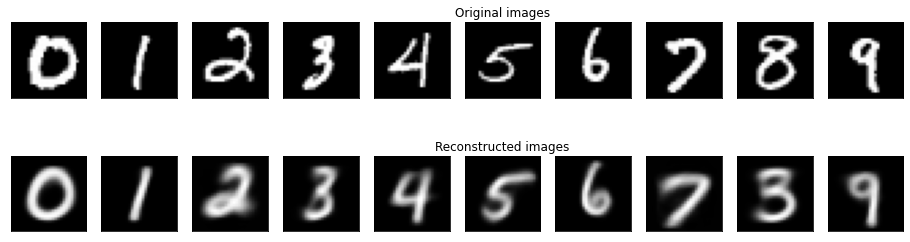

epoch 42/70
training loss: 34.9114
dev loss: 32.5908


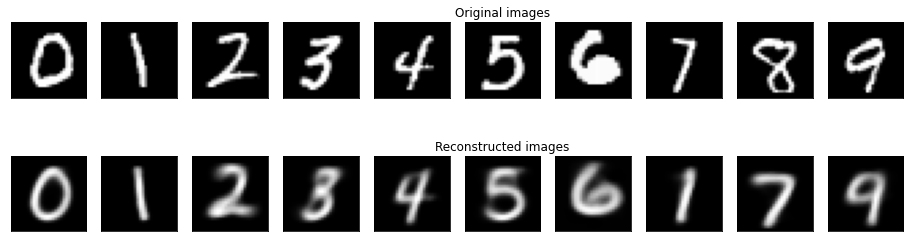

epoch 43/70
training loss: 34.9028
dev loss: 32.5105


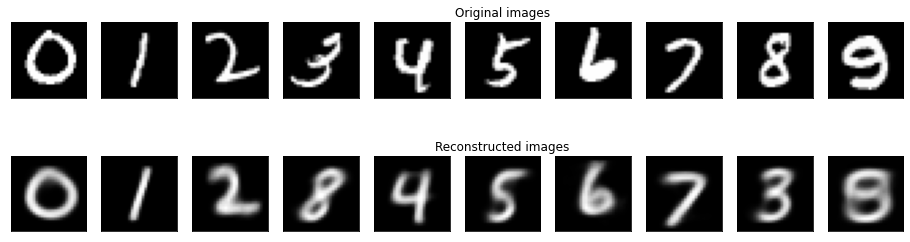

epoch 44/70
training loss: 34.9111
dev loss: 32.7408


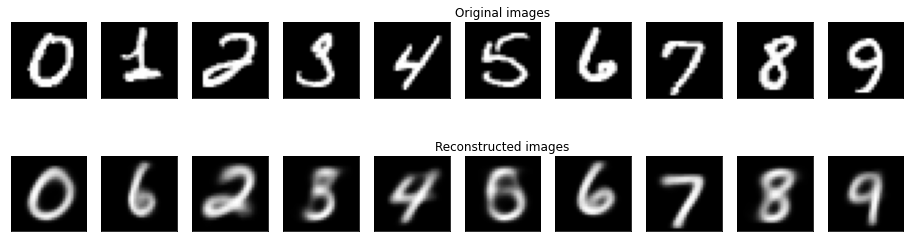

epoch 45/70
training loss: 34.9044
dev loss: 32.6539


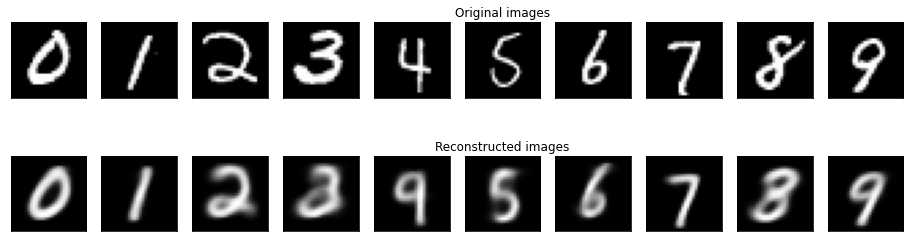

epoch 46/70
training loss: 34.8980
dev loss: 32.5124


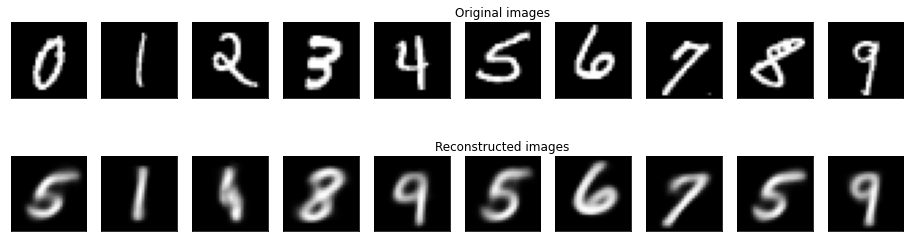

epoch 47/70
training loss: 34.8648
dev loss: 32.4384


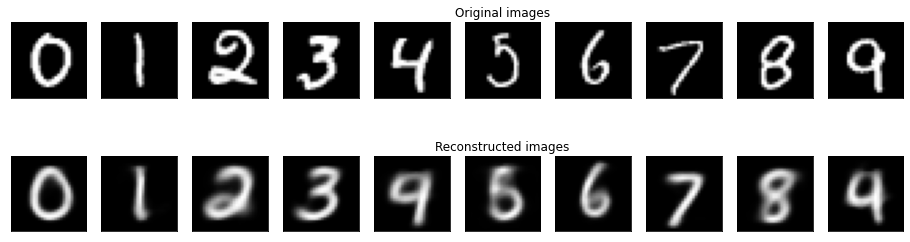

epoch 48/70
training loss: 34.8659
dev loss: 32.4972


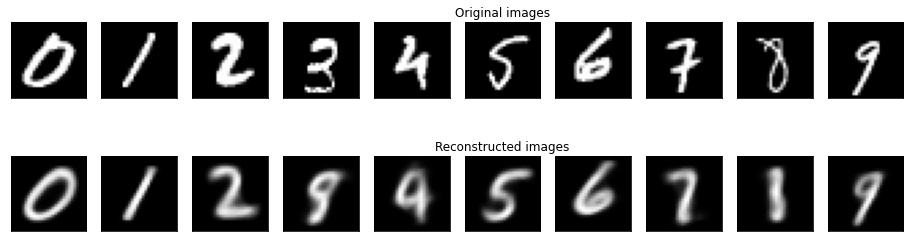

epoch 49/70
training loss: 34.8490
dev loss: 32.4652


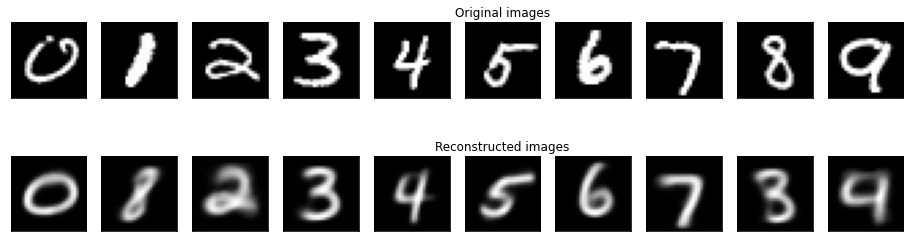

epoch 50/70
training loss: 34.8040
dev loss: 32.3302


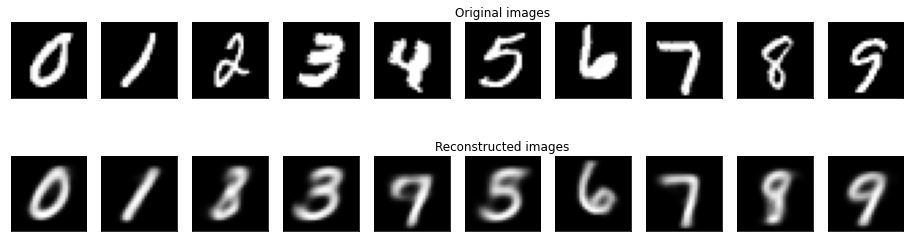

epoch 51/70
training loss: 34.7718
dev loss: 32.3410


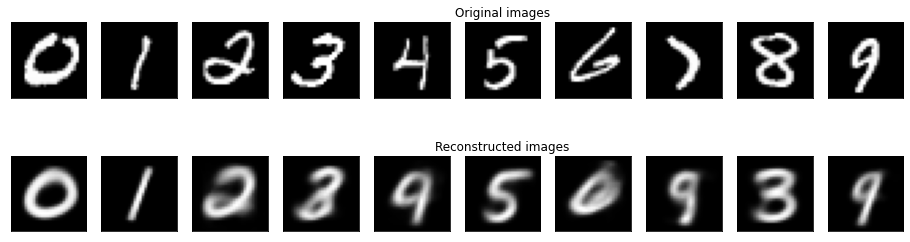

epoch 52/70
training loss: 34.8045
dev loss: 32.4413


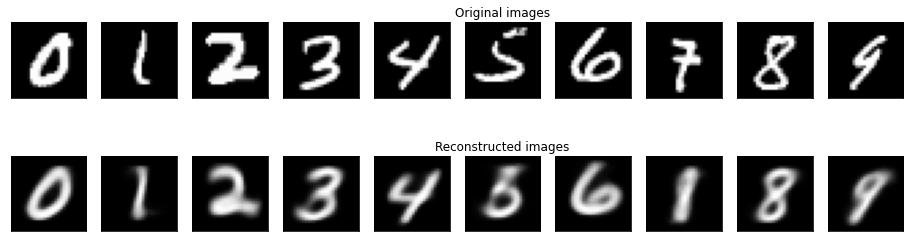

epoch 53/70
training loss: 34.7493
dev loss: 32.3437


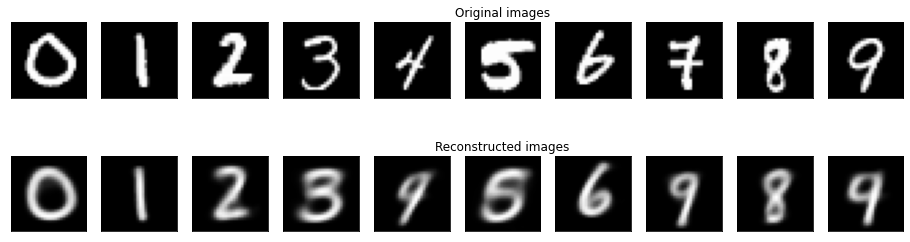

epoch 54/70
training loss: 34.7428
dev loss: 32.2962


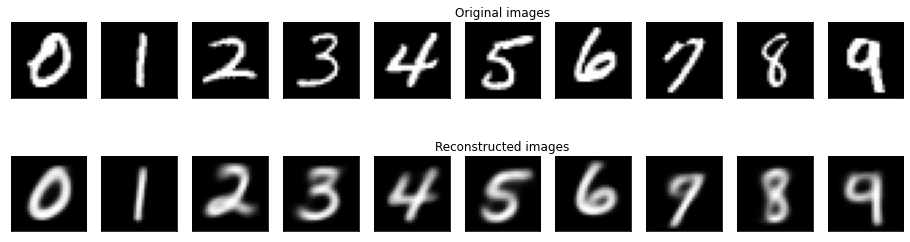

epoch 55/70
training loss: 34.7342
dev loss: 32.3950


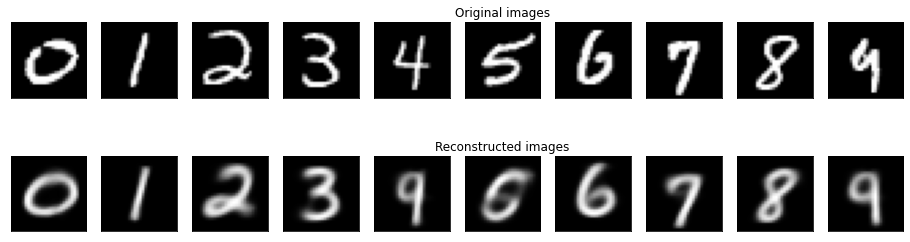

epoch 56/70
training loss: 34.6970
dev loss: 32.2739


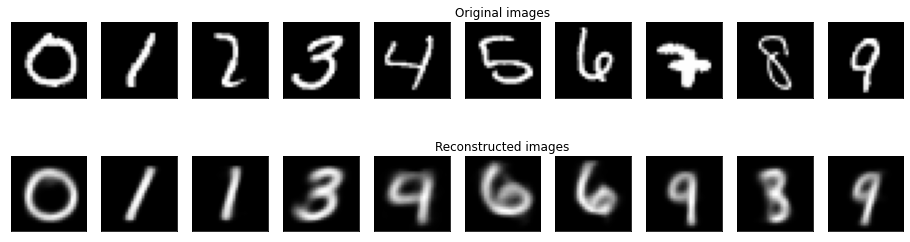

epoch 57/70
training loss: 34.7195
dev loss: 32.3217


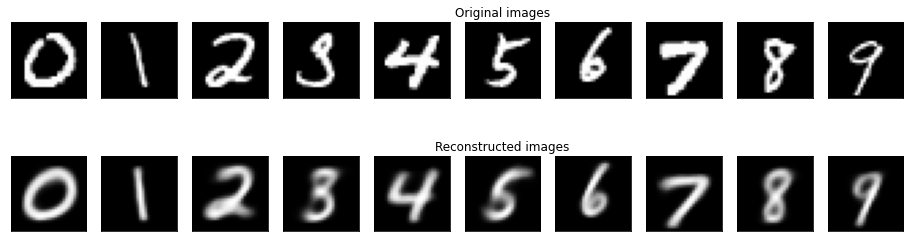

epoch 58/70
training loss: 34.6950
dev loss: 32.3168


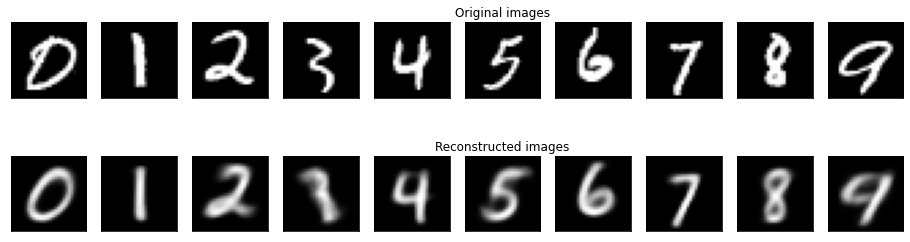

epoch 59/70
training loss: 34.6799
dev loss: 32.2522


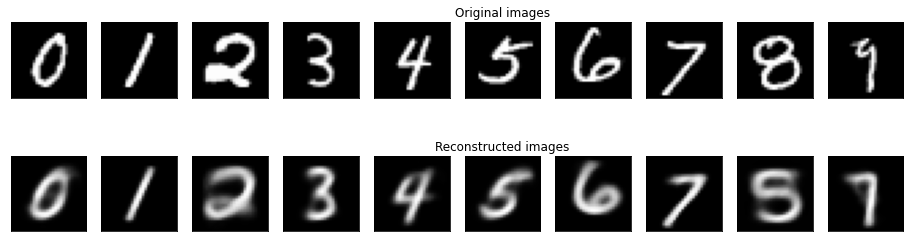

epoch 60/70
training loss: 34.6822
dev loss: 32.1985


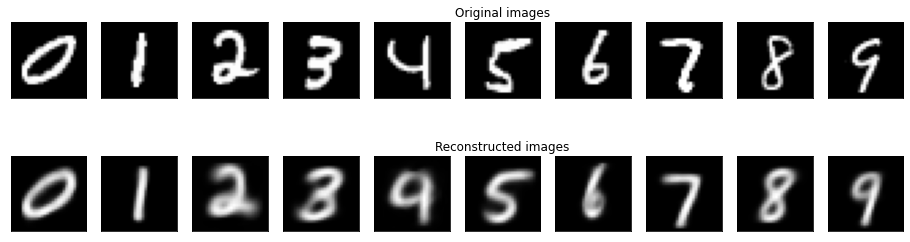

epoch 61/70
training loss: 34.6415
dev loss: 32.3851


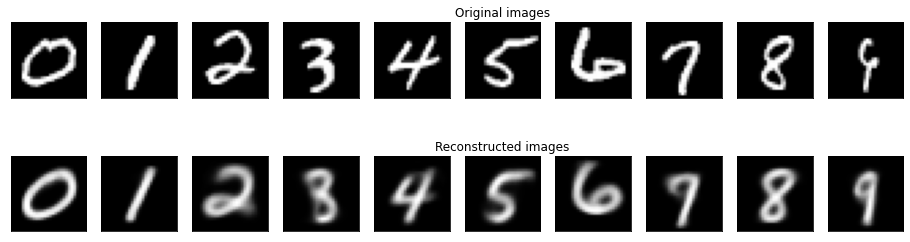

epoch 62/70
training loss: 34.6852
dev loss: 32.2132


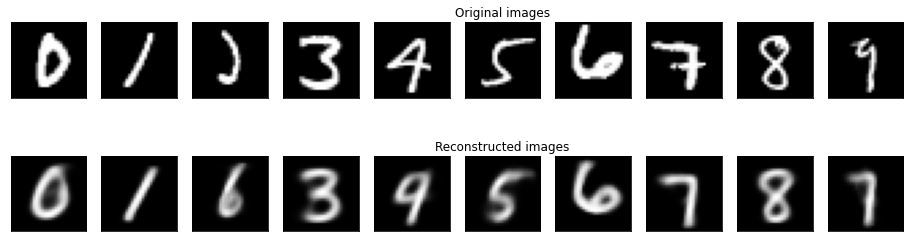

epoch 63/70
training loss: 34.6364
dev loss: 32.3765


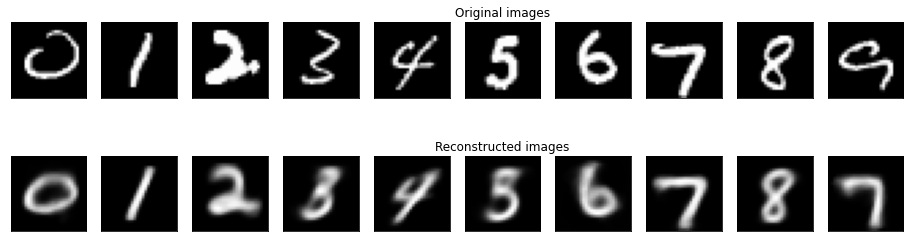

epoch 64/70
training loss: 34.6159
dev loss: 32.2873


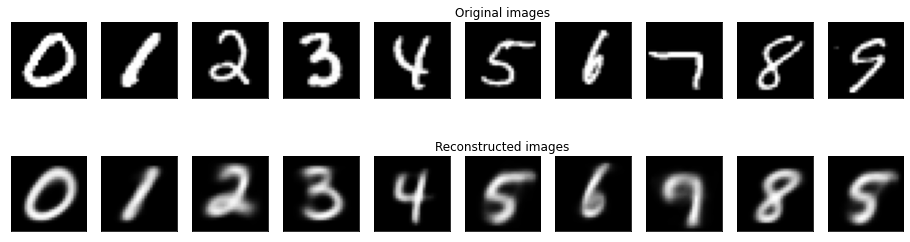

epoch 65/70
training loss: 34.6209
dev loss: 32.2272


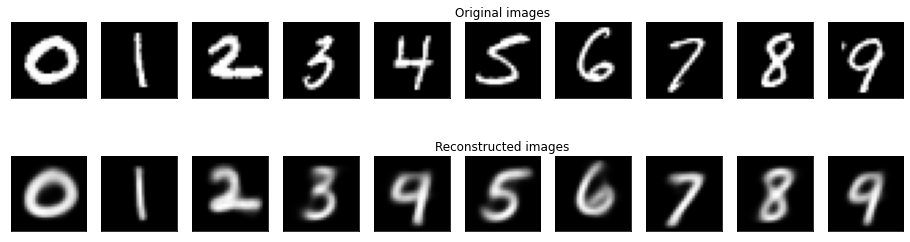

epoch 66/70
training loss: 34.5832
dev loss: 32.1624


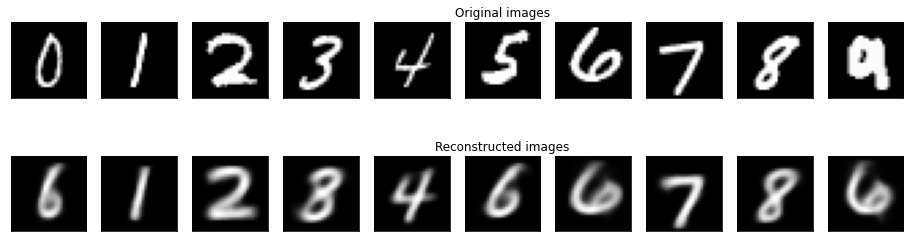

epoch 67/70
training loss: 34.6082
dev loss: 32.2448


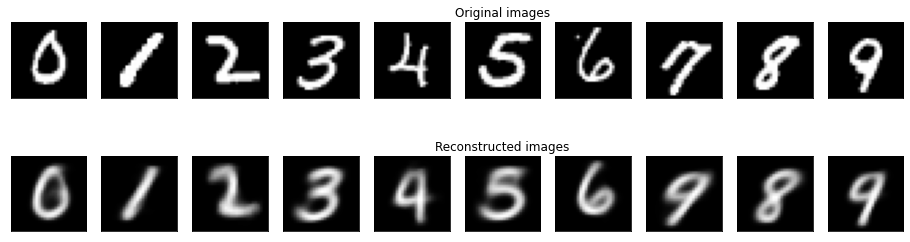

epoch 68/70
training loss: 34.6058
dev loss: 32.1347


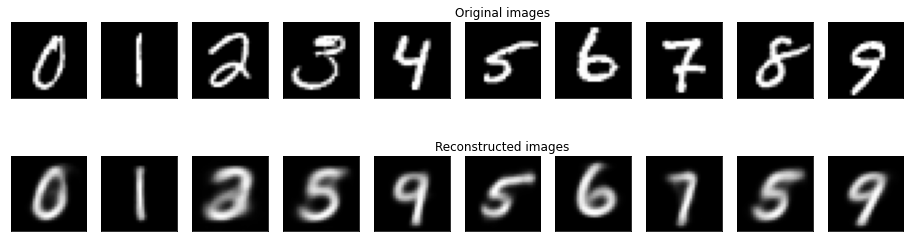

epoch 69/70
training loss: 34.5353
dev loss: 32.1089


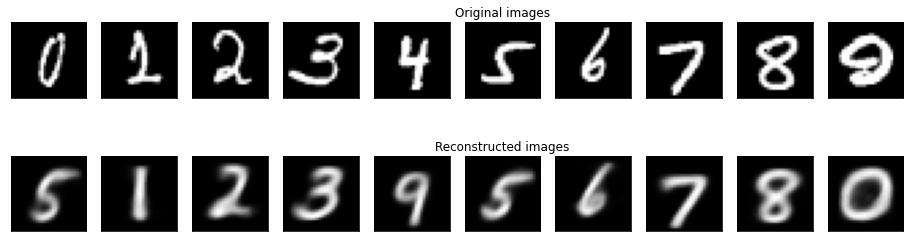

epoch 70/70
training loss: 34.5852
dev loss: 32.2065


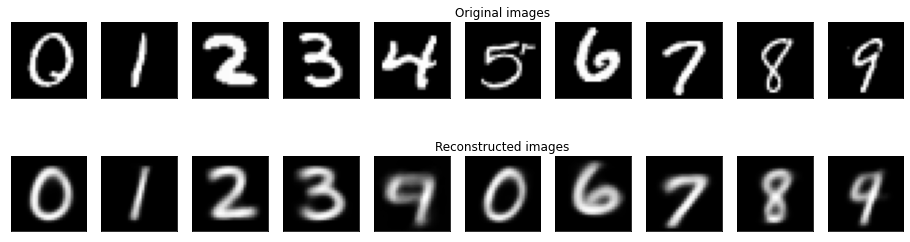

test loss: 32.4791


In [16]:
dim_image = 28 * 28
dim_hidden = [200, 200, 200]
dim_latent = 4
dropout = 0.3
init_channels = 8

vae = VAE(
            dim_image,
            dim_hidden,
            dim_latent,
            init_channels=init_channels,
            dropout=dropout,
            sample_decoder=False
          ).to(device)

optimizer = torch.optim.Adam(vae.parameters(), weight_decay=1e-5)

n_epochs = 70
batch_size = 100

history = training_loop(vae, optimizer, n_epochs, batch_size, verbose=True, plots=True)

## Visualize results

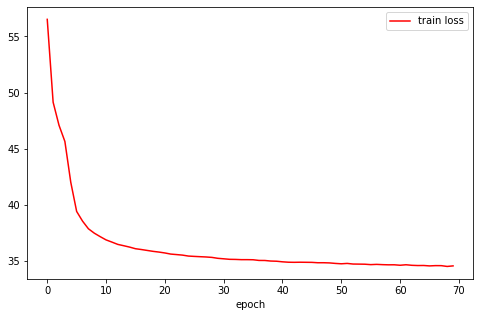

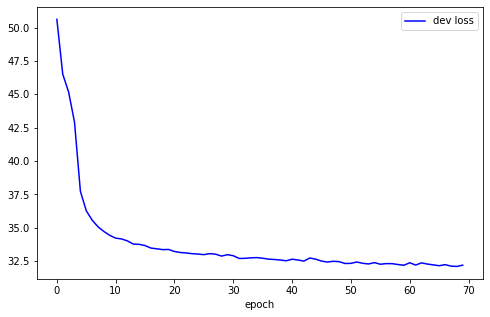

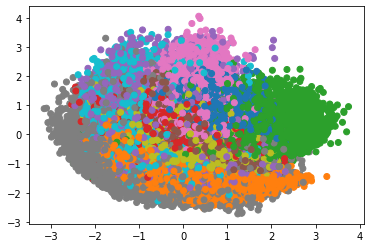

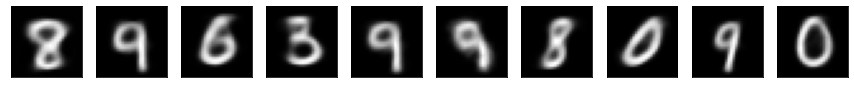

In [17]:
plot_results(history, n_epochs)
visualize_latent_space(vae, train_data, dim_latent, 1000)
plot_random(vae.decoder, 10)